# Load and inspect dataset structure

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from src.eda_utils import salary_per_category_table, salary_per_category_plot, PlotStats

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (9.6, 7.2)

In [3]:
train_features = pd.read_csv('../data/raw/train_features.csv')
train_salaries = pd.read_csv('../data/raw/train_salaries.csv')

In [4]:
print(f'Training features shape: {train_features.shape}')
print(f'Training salaries shape: {train_salaries.shape}')

Training features shape: (1000000, 8)
Training salaries shape: (1000000, 2)


In [5]:
train_features.head(10)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16
5,JOB1362684407692,COMP15,MANAGER,DOCTORAL,COMPSCI,FINANCE,2,31
6,JOB1362684407693,COMP15,CFO,NONE,NONE,HEALTH,23,24
7,JOB1362684407694,COMP24,JUNIOR,BACHELORS,CHEMISTRY,EDUCATION,9,70
8,JOB1362684407695,COMP20,JANITOR,HIGH_SCHOOL,NONE,EDUCATION,1,54
9,JOB1362684407696,COMP41,VICE_PRESIDENT,BACHELORS,CHEMISTRY,AUTO,17,68


In [6]:
train_features[['companyId', 'jobType', 'degree', 'major', 'industry']].apply(lambda x: x.nunique())

companyId    63
jobType       8
degree        5
major         9
industry      7
dtype: int64

In [7]:
train_features.major.value_counts()

NONE           532355
CHEMISTRY       58875
LITERATURE      58684
ENGINEERING     58596
BUSINESS        58518
PHYSICS         58410
COMPSCI         58382
BIOLOGY         58379
MATH            57801
Name: major, dtype: int64

# Target - Salary

In [8]:
train_salaries.head()

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


In [9]:
print("Salary stats:")
train_salaries.salary.describe()

Salary stats:


count    1000000.000000
mean         116.061818
std           38.717936
min            0.000000
25%           88.000000
50%          114.000000
75%          141.000000
max          301.000000
Name: salary, dtype: float64

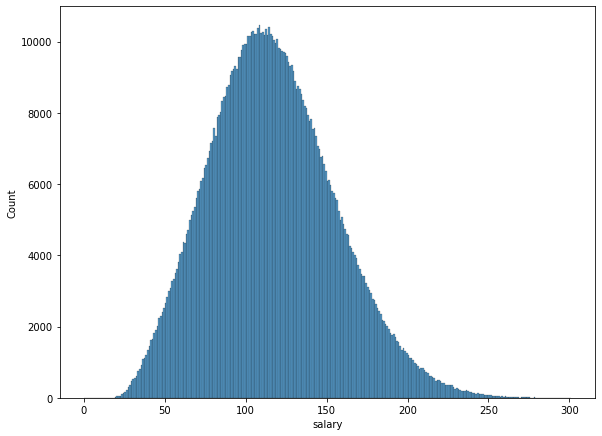

In [10]:
sns.histplot(train_salaries.salary, binwidth = 1)
plt.show()

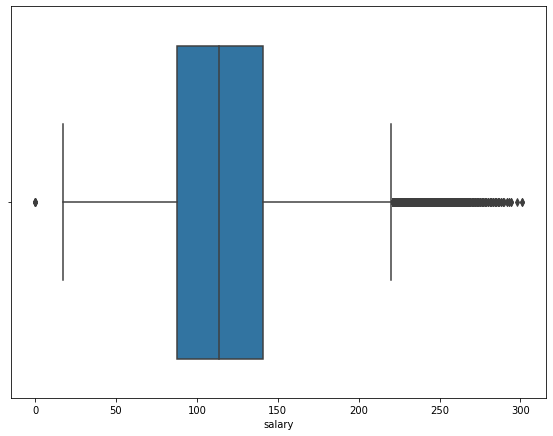

In [11]:
sns.boxplot(x = train_salaries.salary)
plt.show()

### Outliers with zero salary

In [12]:
sum(train_salaries.salary == 0)

5

In [13]:
zero_salary = train_salaries.loc[train_salaries.salary == 0]
zero_salary_ids = set(train_features.jobId).intersection(set(zero_salary.jobId))
train_features.set_index('jobId').loc[zero_salary_ids]

,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
jobId,,,,,,,
JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60
JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25
JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6
JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29
JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7


There does not seem to be an obvious pattern to jobs with zero salary. Jobs with substantial years of experience are especially suspicious.

Could indicate errors in the data; something wrong in the upstream data pipeline. Or they could be normal examples that,for some reason, accurately have 0 salary.


Approaches to consider, for predictive modeling:  
_(assuming questions about data pipeline health and accuracy of the data can't be answered)_
- Treat them as outliers and remove them
- Treat them as missing values and impute salary amounts to them

# Join salary and job description features

In [14]:
salaries_all = train_features.set_index('jobId').join(train_salaries.set_index('jobId'))
salaries_all.reset_index(inplace=True)
salaries_all.head(10)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163
5,JOB1362684407692,COMP15,MANAGER,DOCTORAL,COMPSCI,FINANCE,2,31,113
6,JOB1362684407693,COMP15,CFO,NONE,NONE,HEALTH,23,24,178
7,JOB1362684407694,COMP24,JUNIOR,BACHELORS,CHEMISTRY,EDUCATION,9,70,73
8,JOB1362684407695,COMP20,JANITOR,HIGH_SCHOOL,NONE,EDUCATION,1,54,31
9,JOB1362684407696,COMP41,VICE_PRESIDENT,BACHELORS,CHEMISTRY,AUTO,17,68,104


In [15]:
salaries_all.apply(lambda x: sum(x.isna()))

jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
salary                 0
dtype: int64

In [16]:
salaries_all.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [17]:
salary_stats = PlotStats(salaries_all, 'salary')

### Check duplicates

In [18]:
any(salaries_all.jobId.duplicated())

False

In [19]:
any(salaries_all.duplicated())

False

# Categorical Features

Explore the relationship between salary and the following variables and salary:
- jobType
- degree
- major
- industry

#### Utility functions
 
Helper functions to inspect average salary across different groupings of the categorical features:  

_(click to refer to function definition)_

1. [salary_per_category_table()](https://github.com/scottwiles/salary_prediction/blob/0d9bf55a592badd9afa066c63e7269daad44f186/src/eda_utils.py#L4) - Calculate the mean salary per the specified category and return the resulting dataframe
2. [salary_per_category_plot()](https://github.com/scottwiles/salary_prediction/blob/0d9bf55a592badd9afa066c63e7269daad44f186/src/eda_utils.py#L13) - Plot the average salary per each category using tables generated from the above function



## Salaries per job type

In [20]:
salaries_all.jobType.value_counts()

SENIOR            125886
VICE_PRESIDENT    125235
MANAGER           125121
CTO               125046
JANITOR           124971
CEO               124778
JUNIOR            124594
CFO               124369
Name: jobType, dtype: int64

In [21]:
avg_salary_per_jobtype = salary_per_category_table('jobType', salaries_all)
avg_salary_per_jobtype

,jobType,salary
0,JANITOR,70.813045
1,JUNIOR,95.331557
2,SENIOR,105.487775
3,MANAGER,115.367596
4,VICE_PRESIDENT,125.367629
5,CFO,135.458547
6,CTO,135.479983
7,CEO,145.311425


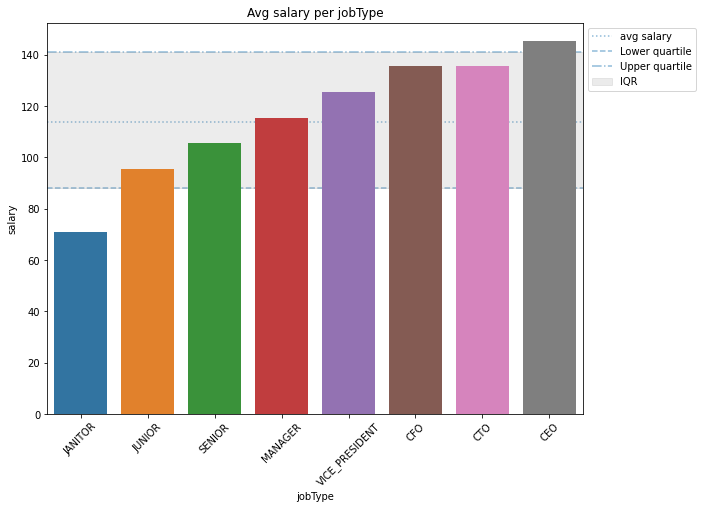

In [22]:
plt.figure()
salary_per_category_plot('jobType', avg_salary_per_jobtype)
salary_stats.plot_IQR()
plt.show()

## Salaries per degree

In [23]:
avg_salary_per_degree = salary_per_category_table('degree', salaries_all)
avg_salary_per_degree

,degree,salary
0,NONE,98.176467
1,HIGH_SCHOOL,101.920654
2,BACHELORS,125.454663
3,MASTERS,130.504903
4,DOCTORAL,135.489433


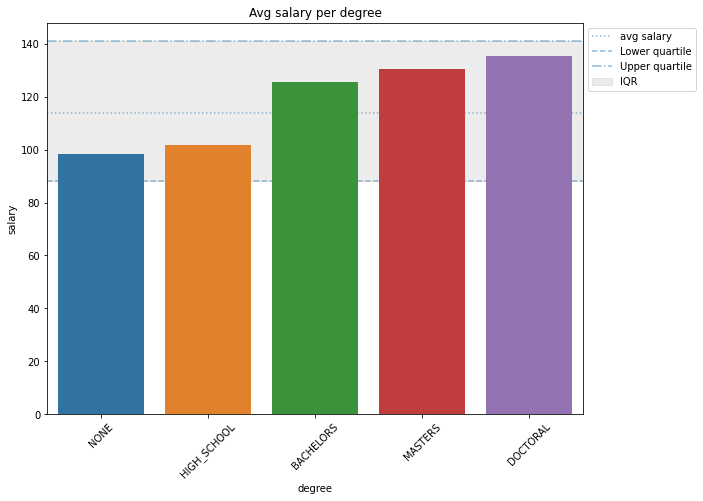

In [24]:
plt.figure()
salary_per_category_plot('degree', avg_salary_per_degree)
salary_stats.plot_IQR()
plt.show()

Having education beyond high school seems to play a big role in increased salary. However the gains from bachelors to graduate and post graduate degrees seem to be smaller.

## Salaries per major

In [25]:
avg_salary_per_major = salary_per_category_table('major', salaries_all)
avg_salary_per_major

,major,salary
0,NONE,102.583479
1,LITERATURE,124.423097
2,BIOLOGY,127.932664
3,CHEMISTRY,129.072085
4,PHYSICS,130.372436
5,COMPSCI,132.075605
6,MATH,133.319735
7,BUSINESS,135.648980
8,ENGINEERING,138.436617


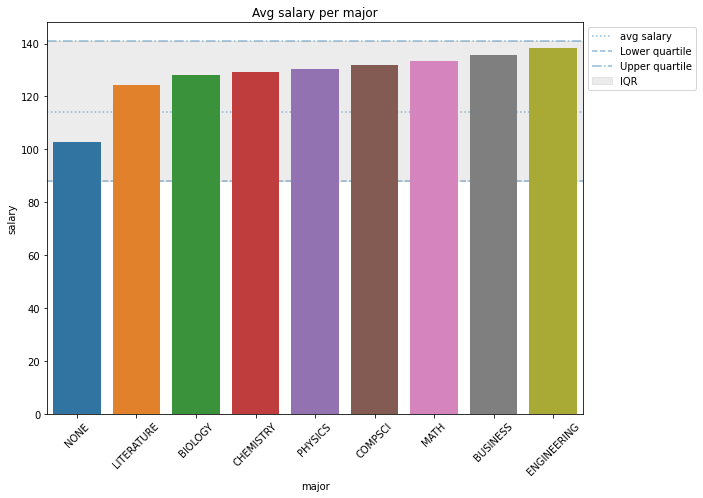

In [26]:
plt.figure()
salary_per_category_plot('major', avg_salary_per_major)
salary_stats.plot_IQR()
plt.show()

## Salaries per industry

In [27]:
avg_salary_per_industry = salary_per_category_table('industry', salaries_all)
avg_salary_per_industry

,industry,salary
0,EDUCATION,99.448386
1,SERVICE,104.446820
2,AUTO,109.433690
3,HEALTH,115.735540
4,WEB,121.644512
5,FINANCE,130.746743
6,OIL,130.952946


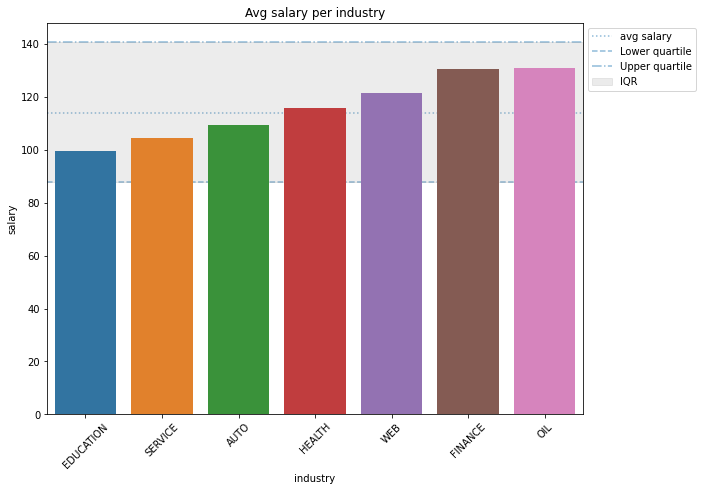

In [28]:
plt.figure()
salary_per_category_plot('industry', avg_salary_per_industry)
salary_stats.plot_IQR()
plt.show()

## Salaries per job and degree

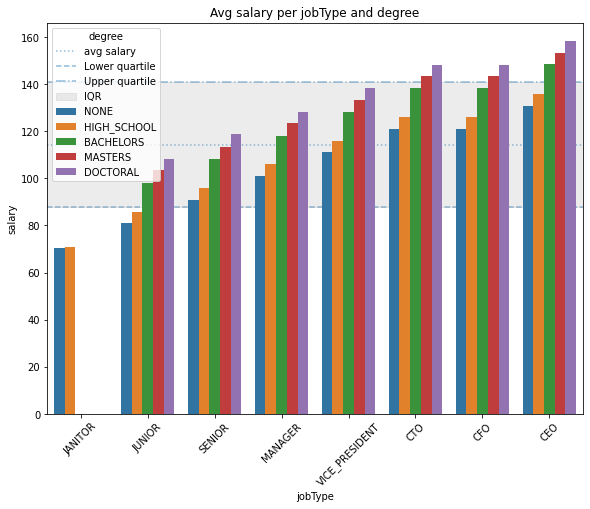

In [29]:
salary_per_degree_and_jobtype = salary_per_category_table(['jobType', 'degree'], salaries_all)

plt.figure()
salary_per_category_plot(['jobType', 'degree'], salary_per_degree_and_jobtype)
salary_stats.plot_IQR()
plt.show()

## Salaries per job and industry

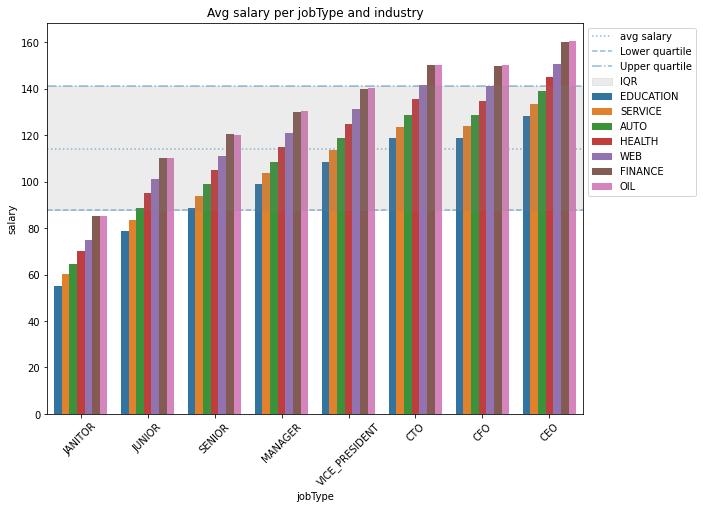

In [32]:
salary_per_jobtype_and_industry = salary_per_category_table(['jobType', 'industry'], salaries_all)

plt.figure()
salary_per_category_plot(['jobType', 'industry'], salary_per_jobtype_and_industry)
salary_stats.plot_IQR()
plt.show()

## Salaries per job and major

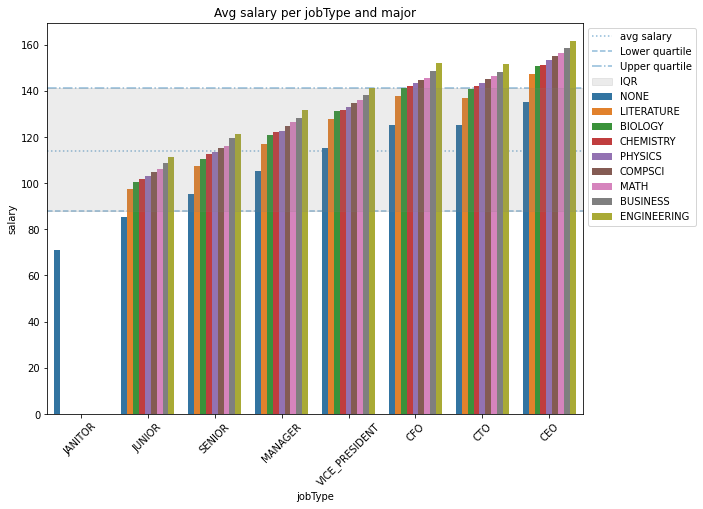

In [33]:
salary_per_job_and_major = salary_per_category_table(['jobType', 'major'], salaries_all)

plt.figure()
salary_per_category_plot(['jobType', 'major'], salary_per_job_and_major)
salary_stats.plot_IQR()
plt.show()

# Continuous Features

## Miles from metropolis

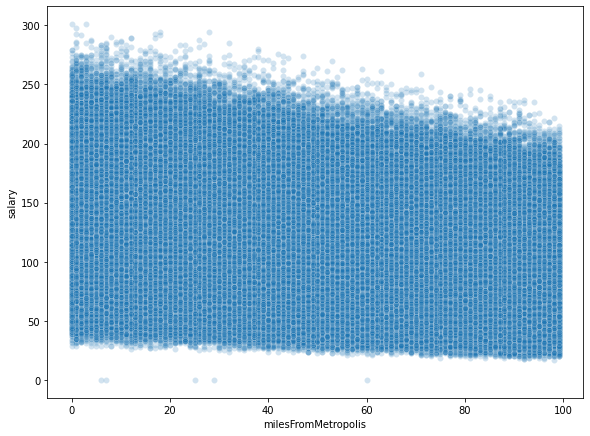

In [30]:
sns.scatterplot(x = salaries_all.milesFromMetropolis, y = salaries_all.salary, alpha = 0.2)
plt.show()

In [31]:
avg_salary_per_distance = salaries_all.groupby('milesFromMetropolis').salary.mean()

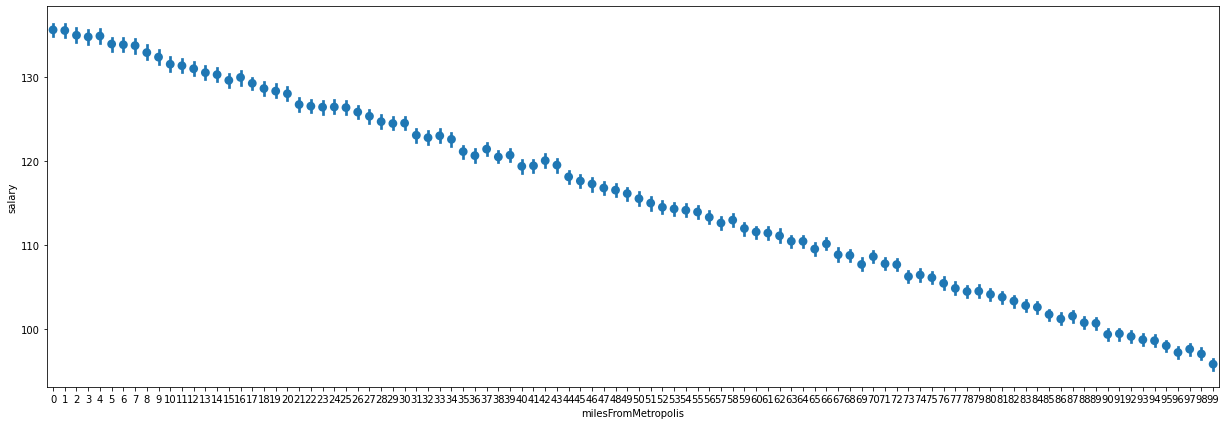

In [32]:
plt.figure(figsize = (21,7))
sns.pointplot(x = salaries_all.milesFromMetropolis, y = salaries_all.salary, join = False)
plt.show()

F:\Code\Data Science Projects\salary_prediction\.venv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


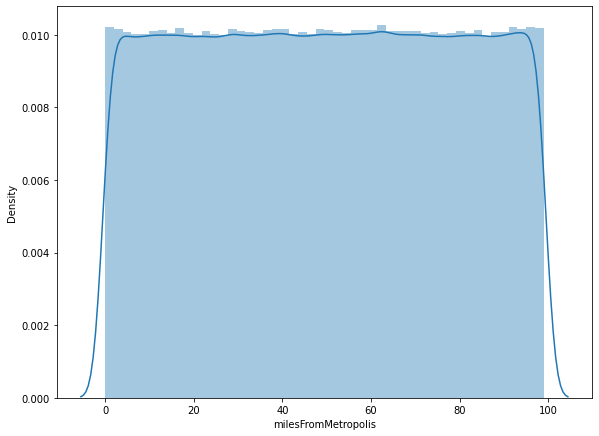

In [33]:
sns.distplot(salaries_all.milesFromMetropolis)
plt.show()

## Years of experience

There are a handful of instances with 0 salary.

These could be outliers, errors in the data or they could even be typical (although rare) examples that we could expect in future real world examples. More context about how the upstream data pipeline would be useful information for how to handle cases with 0 salary.

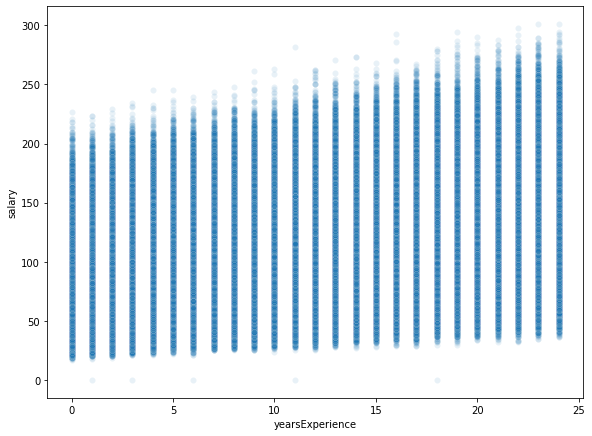

In [34]:
sns.scatterplot(x = salaries_all.yearsExperience, y = salaries_all.salary, alpha = 0.1)
plt.show()

F:\Code\Data Science Projects\salary_prediction\.venv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


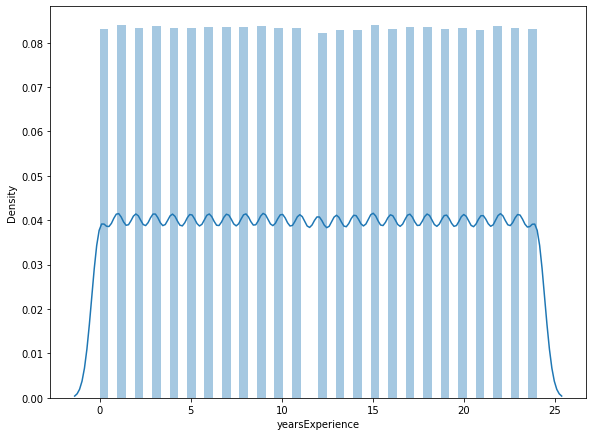

In [35]:
sns.distplot(salaries_all.yearsExperience)
plt.show()